In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange

In [14]:
def f(x):
    if 1 <= x <= 3:
        return 1
    if -4.5 <= x <= -2.5:
        return (np.sin(np.pi * x) + 1) / 2
    
    if x < -5:
        return f(x+10) # for periodicity
    if x > 5:
        return f(x-10) # for periodicity
    
    return 0

def ff(xx):
    return np.array([f(x) for x in xx])

In [15]:
def step_upwind(X, QQ, u, dt, dX):
    Q_next = np.zeros_like(QQ) # make a vector to store the result
    
    def Q(i): # easier periodic boundaries
        return np.take(QQ, i, mode="wrap") 
    
    for i in range(len(Q_next)):
        Q_next[i] = Q(i) - u * dt / dX[i] * (Q(i) - Q(i - 1))
    
    return Q_next


def step_LaxWendroff(X, QQ, u, dt, dX):
    Q_next = np.zeros_like(QQ) # make a vector to store the result
    
    def Q(i): # easier periodic boundaries
        return np.take(QQ, i, mode="wrap") 
    
    def dx(i):
        return np.take(dX, i, mode="wrap") 
    
    for i in range(len(Q_next)):
        dximh = 0.5 * (dx(i) + dx(i-1))
        dxiph = 0.5 * (dx(i) + dx(i+1))
        
        Q_next[i] = Q(i) - u * dt / dx(i) * (Q(i) - Q(i - 1)) - 0.5 * u * dt / dx(i) * (
            (dx(i) - u * dt) / dxiph * (Q(i+1) - Q(i)) - (dx(i-1) - u * dt) / dximh * (Q(i) - Q(i-1))
        )
        
    return Q_next

# advection equation

Steps per period: 250.0


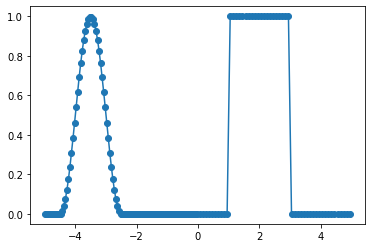

In [16]:
u = 1

dx_big = 0.1
dx_small = dx_big / 2


dt = 0.04
T = 10
steps_per_period = T / dt
print("Steps per period:", steps_per_period)
steps_per_period = int(steps_per_period)

x_left = -5
x_middle = 0
x_right = 5


X_left  = np.linspace(x_left  , x_middle, int((x_middle - x_left  ) / dx_small), endpoint=False) + 0.5 * dx_small
X_right = np.linspace(x_middle,  x_right, int((x_right  - x_middle) / dx_big  ), endpoint=False) + 0.5 * dx_big

# X = X_left + X_right
X = np.hstack([X_left, X_right])
dX = np.hstack([np.ones_like(X_left) * dx_small, np.ones_like(X_right) * dx_big])
Q0 = ff(X)

plt.plot(X, Q0, marker='o')

In [17]:
def get_solutions(dx_big=0.1, dt=0.04, n_periods=5, method=step_LaxWendroff):
    u = 1
    dx_small = dx_big / 2

    T = 10
    steps_per_period = T / dt
    print("Steps per period:", steps_per_period)
    steps_per_period = int(steps_per_period + 0.5)

    x_left = -5
    x_middle = 0
    x_right = 5


    X_left  = np.linspace(x_left  , x_middle, int((x_middle - x_left  ) / dx_small), endpoint=False) + 0.5 * dx_small
    X_right = np.linspace(x_middle,  x_right, int((x_right  - x_middle) / dx_big  ), endpoint=False) + 0.5 * dx_big

    # X = X_left + X_right
    X = np.hstack([X_left, X_right])
    dX = np.hstack([np.ones_like(X_left) * dx_small, np.ones_like(X_right) * dx_big])
    Q0 = ff(X)

    print(f"CFL left : {u*dt / dx_small:.1f}")
    print(f"CFL right: {u*dt / dx_big:.1f}")
    print(f"timesteps: {steps_per_period}" )
    
    QQ = []
    Q = Q0
    for i in trange(n_periods * steps_per_period + 1):
        if i % steps_per_period == 0:
            QQ.append(Q)
        Q = method(X, Q, u, dt, dX)
    
    return X, dX, QQ


Steps per period: 400.0
CFL left : 0.5
CFL right: 0.2
timesteps: 400


  0%|          | 0/2001 [00:00<?, ?it/s]

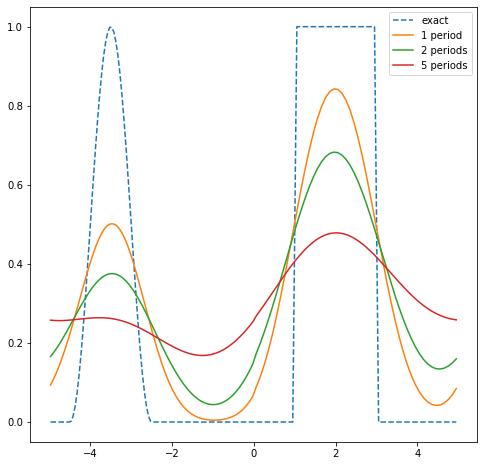

In [18]:
X, dX, qq = get_solutions(0.1, 0.025, 5, step_upwind)

plt.figure(figsize=(8,8))
plt.plot(X, qq[0], '--', label="exact")
plt.plot(X, qq[1], label="1 period")
plt.plot(X, qq[2], label="2 periods")
plt.plot(X, qq[5], label="5 periods")
plt.legend()
plt.savefig("img/upwind_advection_varying_grid_CFL0.5.png")

Steps per period: 400.0
CFL left : 0.5
CFL right: 0.2
timesteps: 400


  0%|          | 0/2001 [00:00<?, ?it/s]

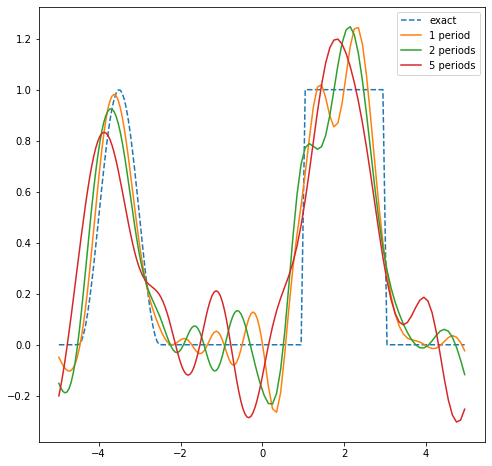

In [19]:
X, dX, qq = get_solutions(0.1, 0.025, 5, step_LaxWendroff)

plt.figure(figsize=(8,8))
plt.plot(X, qq[0], '--', label="exact")
plt.plot(X, qq[1], label="1 period")
plt.plot(X, qq[2], label="2 periods")
plt.plot(X, qq[5], label="5 periods")
plt.legend()
plt.savefig("img/laxwendroff_advection_varying_grid_CFL0.5.png")

Steps per period: 250.0
CFL left : 0.8
CFL right: 0.4
timesteps: 250


  0%|          | 0/1251 [00:00<?, ?it/s]

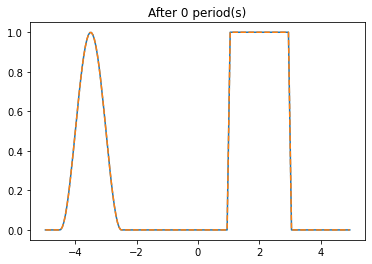

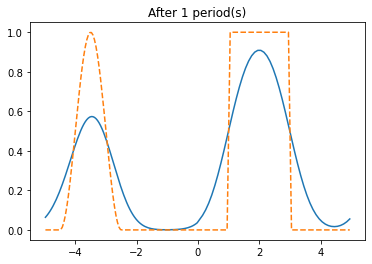

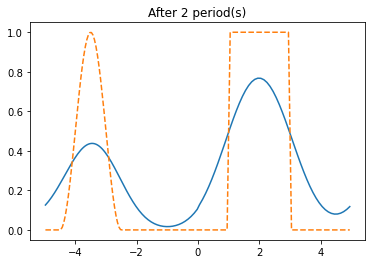

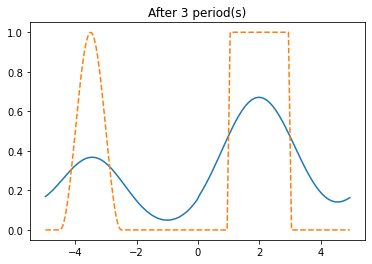

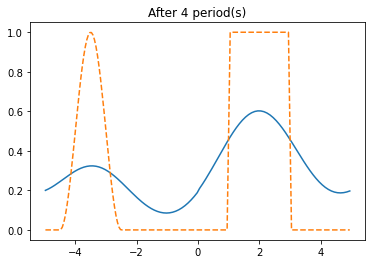

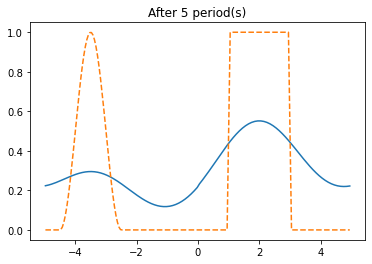

In [20]:
X, dX, qq = get_solutions(0.1, 0.04, 5, step_upwind)
for i, q in enumerate(qq):
    plt.figure()
    plt.title(f"After {i} period(s)")
    plt.plot(X, q)
    plt.plot(X, qq[0], '--')

In [62]:
def get_err(dx_small, CFL, method=step_LaxWendroff):
    X, dX, qq = get_solutions(2 * dx_small, CFL * dx_small, 5, method)
    
    err1 = np.linalg.norm(dX * (qq[1] - qq[0]), 2)
    err5 = np.linalg.norm(dX * (qq[5] - qq[0]), 2)
    return err1, err5

dxs = [0.5, 0.25, 1/10, 1/20, 1/40]

CFL = 20/19

err_upwind = []
err_lw = []
for dx in dxs:
    err_upwind.append(get_err(dx, CFL, step_upwind))
    err_lw.append(get_err(dx, CFL, step_LaxWendroff))

Steps per period: 19.0
CFL left : 1.1
CFL right: 0.5
timesteps: 19


  0%|          | 0/96 [00:00<?, ?it/s]

Steps per period: 19.0
CFL left : 1.1
CFL right: 0.5
timesteps: 19


  0%|          | 0/96 [00:00<?, ?it/s]

Steps per period: 38.0
CFL left : 1.1
CFL right: 0.5
timesteps: 38


  0%|          | 0/191 [00:00<?, ?it/s]

Steps per period: 38.0
CFL left : 1.1
CFL right: 0.5
timesteps: 38


  0%|          | 0/191 [00:00<?, ?it/s]

Steps per period: 95.0
CFL left : 1.1
CFL right: 0.5
timesteps: 95


  0%|          | 0/476 [00:00<?, ?it/s]

Steps per period: 95.0
CFL left : 1.1
CFL right: 0.5
timesteps: 95


  0%|          | 0/476 [00:00<?, ?it/s]

Steps per period: 190.0
CFL left : 1.1
CFL right: 0.5
timesteps: 190


  0%|          | 0/951 [00:00<?, ?it/s]

Steps per period: 190.0
CFL left : 1.1
CFL right: 0.5
timesteps: 190


  0%|          | 0/951 [00:00<?, ?it/s]

Steps per period: 380.0
CFL left : 1.1
CFL right: 0.5
timesteps: 380


  0%|          | 0/1901 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
xt = dxs
xl = dxs

yt = None
yl = None

yt = np.hstack([np.arange(0.1, 1, 0.1), np.arange(1, 6, 1),])
yl = [f"{y:.1f}" for y in yt]


plt.figure(figsize=(6,6))
plt.loglog(dxs, np.array(err_upwind)[:,0], label='Upwind', marker='o', color='blue')
plt.loglog(dxs, np.array(err_lw)[:,0], label='Lax Wendroff', marker='o', color='green')
plt.xlabel(r"$\Delta x$ (small grid)")
plt.ylabel(r"$L_2$-norm")

plt.xticks(dxs, dxs)
if yt is not None:
    plt.yticks(yt, yl)
plt.legend()
plt.savefig(f"img/two_grid_CFL{CFL:.2f}_period1.png")



plt.figure(figsize=(6,6))
plt.loglog(dxs, np.array(err_upwind)[:,1], label='Upwind', marker='o', color='blue')
# plt.loglog(dxs, np.array(err_lw)[:,1], label='Lax Wendroff', marker='o', color='green')
plt.xlabel(r"$\Delta x$ (small grid)")
plt.ylabel(r"$L_2$-norm")

plt.xticks(dxs, dxs)
if yt is not None:
    plt.yticks(yt, yl)
plt.legend()
plt.savefig(f"img/two_grid_CFL{CFL:.2f}_period5.png")


In [59]:
10/18

0.5555555555555556